In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import xarray as xr

from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
from matplotlib.colors import TwoSlopeNorm

from nc_time_axis import CFTimeFormatter

from fme_diags.utils import get_run_kwargs, load_config, open_autoregressive_inference
from fme_diags.hovmoller import (
    compute_daily_anomalies, remove_rolling_mean,
    plot_hovmoller_by_lon, plot_hovmoller_by_lat
)
    
_ = xr.set_options(keep_attrs=True)

In [2]:
if not "RUN_KEY" in os.environ:
    RUN_KEY = "42yrs-batch_size8-max_epochs50-lr3e-4-run4-ema"
else:
    RUN_KEY = os.environ["RUN_KEY"]

In [3]:
config = load_config("./preds.yaml")
run_kwargs = get_run_kwargs(config, RUN_KEY)

if run_kwargs["flip_lat"]:
    LAT_SLICE = slice(-15, 15)
else:
    LAT_SLICE = slice(15, -15)

# plot final year of inference
TIME_INDEX_SLICE = slice(3285, None)

PRECIP_FACTOR = 86400.0
PRECIP_UNITS = "mm/day"

run_kwargs

{'path': '/pscratch/sd/j/jpduncan/ai2/datasets/2023-11-22-e3smv2-vertically-resolved-1deg-fme-dataset/output/42-years-training-set/42yrs-batch_size8-max_epochs50-lr3e-4-run4-ema/autoregressive_predictions.nc',
 'start': '0054-01-01',
 'step_dim': 'lead',
 'step_freq': '6H',
 'calendar': 'noleap',
 'flip_lat': False,
 'chunks': {'lead': 178}}

In [4]:
FIG_PREFIX = "hovmoller"
OUTDIR = f"figs/{RUN_KEY}"
os.makedirs(OUTDIR, exist_ok=True)

In [5]:
ds = open_autoregressive_inference(**run_kwargs)
ds

<xarray.Dataset>
Dimensions:                                        (time: 14597, sample: 1,
                                                    source: 2, lat: 180,
                                                    lon: 360)
Coordinates:
  * time                                           (time) object 0054-01-01 0...
    init                                           (sample) object dask.array<chunksize=(1,), meta=np.ndarray>
    valid_time                                     (sample, time) object dask.array<chunksize=(1, 178), meta=np.ndarray>
  * source                                         (source) object 'target' '...
  * lat                                            (lat) float32 89.24 ... -8...
  * lon                                            (lon) float32 0.5 ... 359.5
Dimensions without coordinates: sample
Data variables: (12/49)
    OCNFRAC                                        (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    top_of_atmos_upward_shortwave_flux             (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    FSDS                                           (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    tendency_of_total_water_path_due_to_advection  (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    specific_total_water_1                         (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    PS                                             (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    ...                                             ...
    specific_total_water_7                         (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    U_6                                            (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    V_0                                            (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    FLDS                                           (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    ICEFRAC                                        (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    V_6                                            (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>

In [6]:
da = ds['surface_precipitation_rate'].isel(sample=0) * PRECIP_FACTOR
da.attrs["units"] = PRECIP_UNITS

## Plot daily mean precip for the final year of the validation period

In [7]:
with ProgressBar():
    da_daily_mean = da.sel(lat=LAT_SLICE).resample(time="1D").mean("time").isel(time=TIME_INDEX_SLICE).compute()

[########################################] | 100% Completed |  2.9s


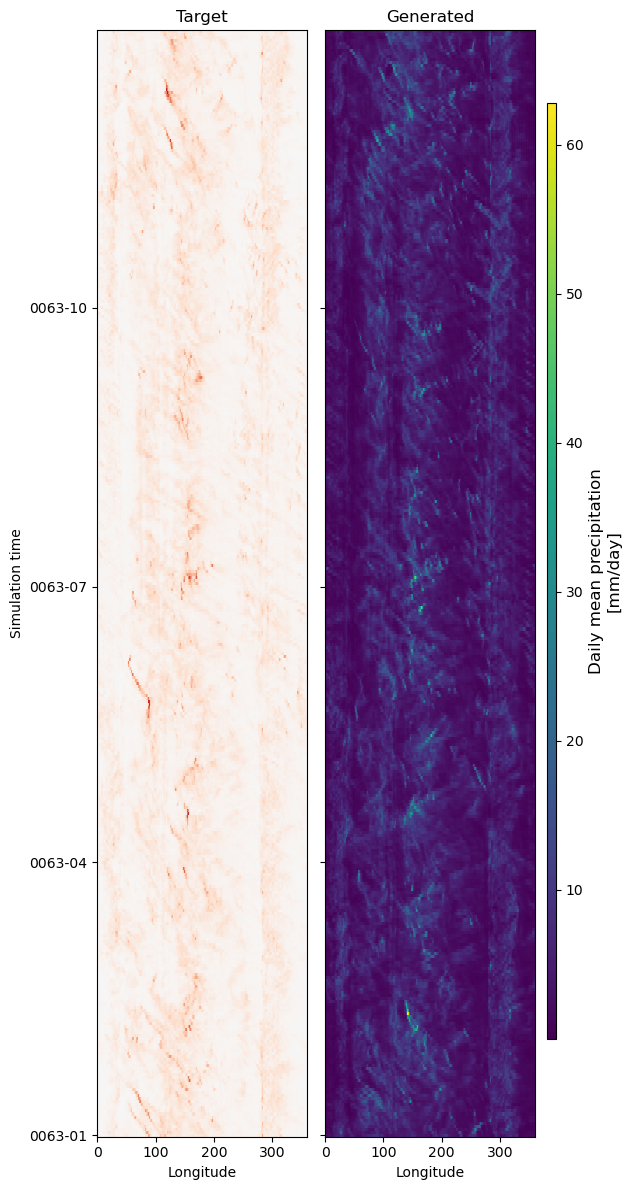

In [8]:
da_lat_mean = da_daily_mean.mean("lat")

fig, axs = plot_hovmoller_by_lon(da_lat_mean, var_name="precipitation")
fig.show()

In [9]:
fig.savefig(os.path.join(OUTDIR, f"{FIG_PREFIX}_fig1.png"), bbox_inches="tight")

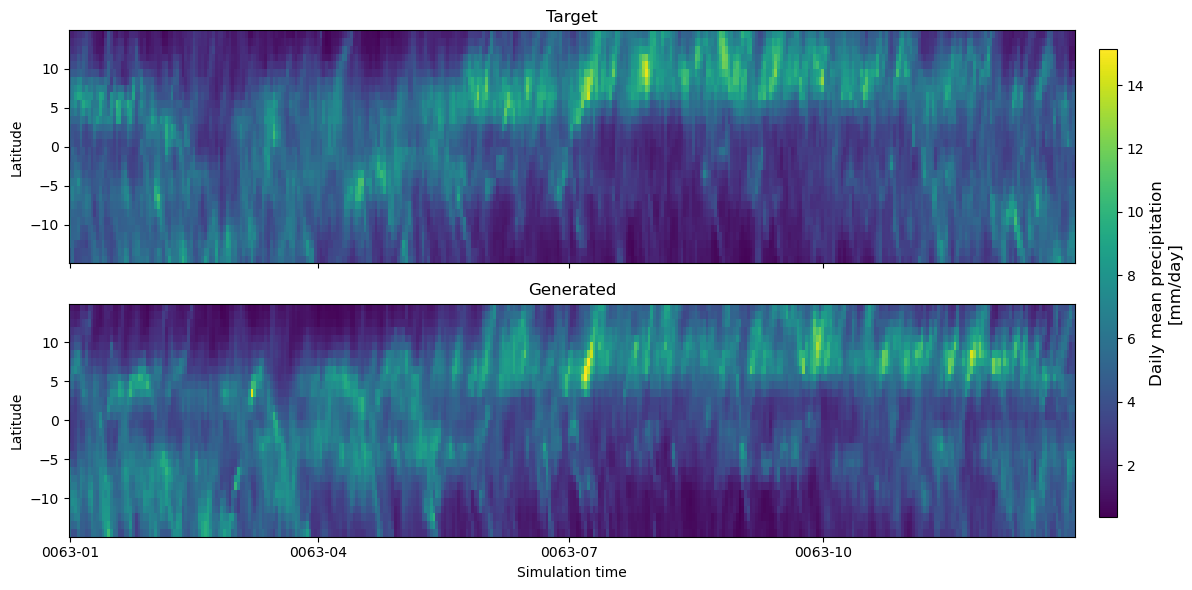

In [10]:
da_lon_mean = da_daily_mean.mean("lon")

fig, axs = plot_hovmoller_by_lat(da_lon_mean, var_name="precipitation")
fig.show()

In [11]:
fig.savefig(os.path.join(OUTDIR, f"{FIG_PREFIX}_fig2.png"), bbox_inches="tight")

## Plot the daily mean precip climatology over all years

In [12]:
with ProgressBar():
    da_day_clim = da.sel(lat=LAT_SLICE).groupby(da["time"].dt.dayofyear).mean("time").compute()

[########################################] | 100% Completed | 24.7s


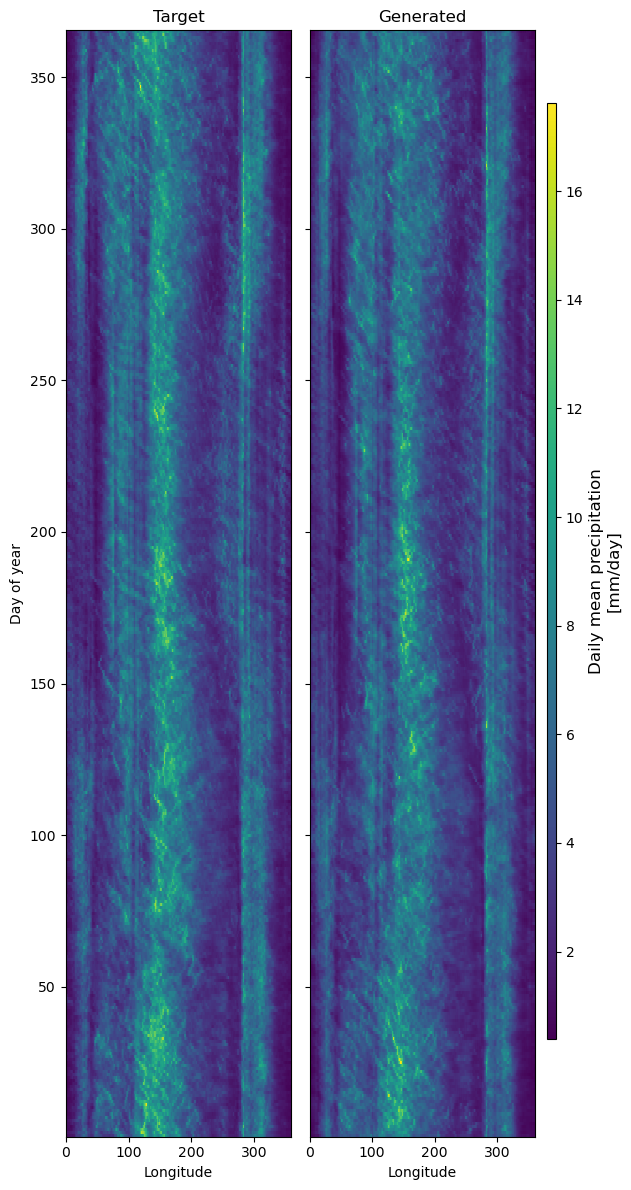

In [13]:
da_lat_mean_clim = da_day_clim.mean("lat")

fig, axs = plot_hovmoller_by_lon(da_lat_mean_clim, var_name="precipitation", time_label="Day of year")
fig.show()

In [14]:
fig.savefig(os.path.join(OUTDIR, f"{FIG_PREFIX}_fig3.png"), bbox_inches="tight")

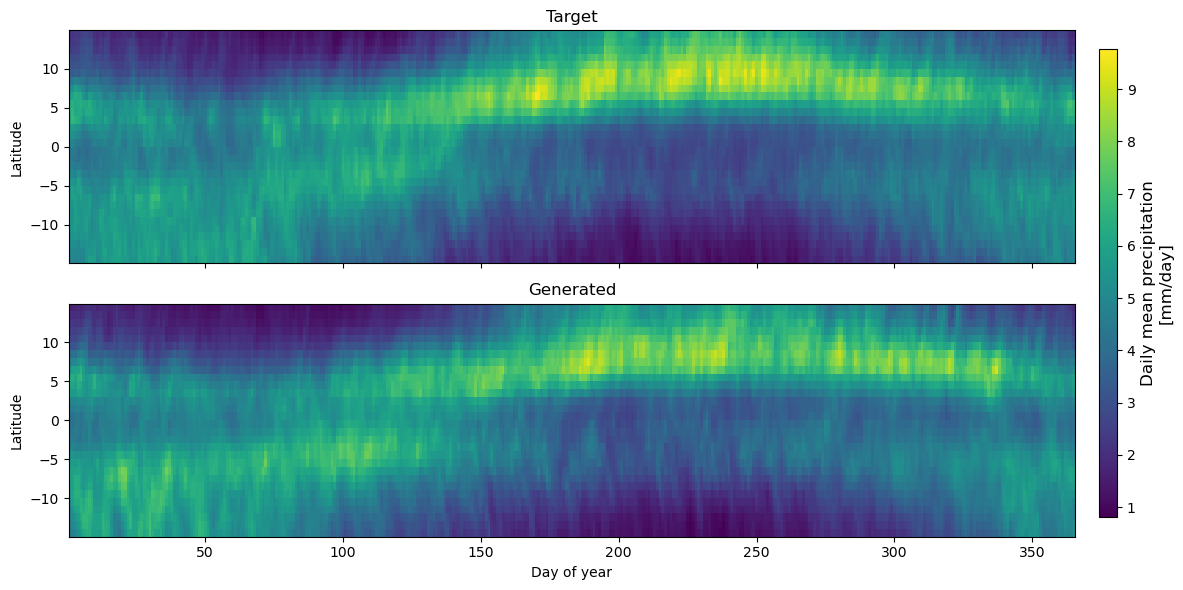

In [15]:
da_lon_mean_clim = da_day_clim.mean("lon")

fig, axs = plot_hovmoller_by_lat(da_lon_mean_clim, var_name="precipitation", time_label="Day of year", time_var="dayofyear")
fig.show()

In [16]:
fig.savefig(os.path.join(OUTDIR, f"{FIG_PREFIX}_fig4.png"), bbox_inches="tight")

# Filter for the MJO before plotting

In [17]:
with ProgressBar():
    da_daily_mean = da.sel(lat=LAT_SLICE).resample(time="1D").mean("time")
    da_anom = compute_daily_anomalies(
        da_daily_mean,
        smoothed=True,
    )
    da_anom_rollmean = remove_rolling_mean(da_anom, samples_per_day=1)
    da_anom_lat_mean = da_anom_rollmean.mean("lat").compute()

[########################################] | 100% Completed | 12.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100

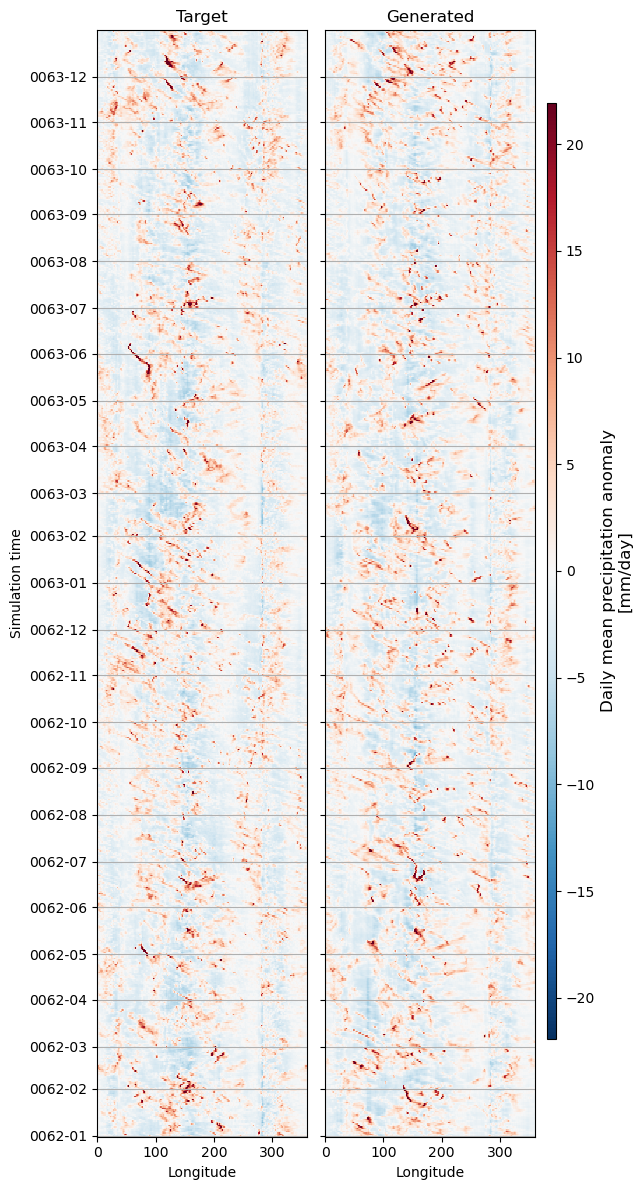

In [19]:
vmax_abs = np.quantile(np.abs(da_anom_lat_mean.isel(time=slice(-730, None))), 0.999)

fig, axs = plot_hovmoller_by_lon(
    da_anom_lat_mean.isel(time=slice(-730, None)), 
    var_name="precipitation anomaly",
    norm=TwoSlopeNorm(0.0, -vmax_abs, vmax_abs),
    cmap="RdBu_r"
)

yticks = xr.cftime_range(
    da_anom_lat_mean["time"][-730].item(),
    da_anom_lat_mean["time"][-1].item(),
    freq="MS",
    calendar="noleap"
).values                     

axs[0].set_yticks(yticks)
axs[0].yaxis.set_major_formatter(CFTimeFormatter("%Y-%m", "noleap"))
axs[0].grid(axis="y")
axs[1].grid(axis="y")

fig.show()

In [20]:
fig.savefig(os.path.join(OUTDIR, f"{FIG_PREFIX}_fig5.png"), bbox_inches="tight")

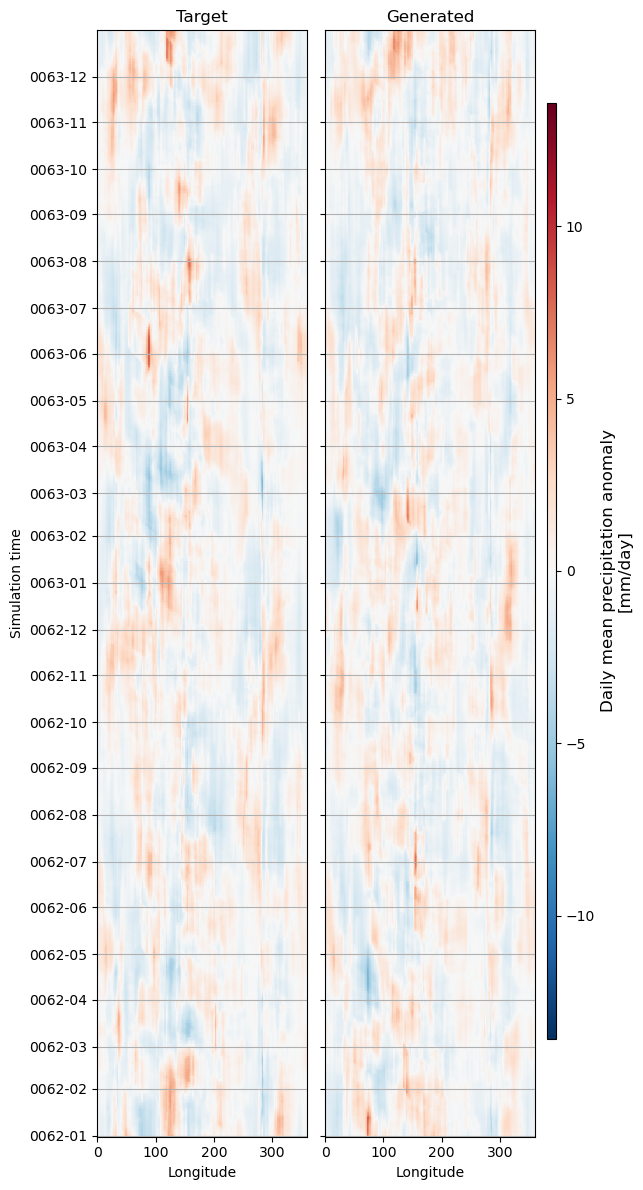

In [21]:
da_anom_lat_mean_rolling = da_anom_lat_mean.rolling(time=30).mean()

vmax_abs = np.abs(da_anom_lat_mean_rolling).max()

fig, axs = plot_hovmoller_by_lon(
    da_anom_lat_mean_rolling.isel(time=slice(-730, None)), 
    var_name="precipitation anomaly",
    norm=TwoSlopeNorm(0.0, -vmax_abs, vmax_abs),
    cmap="RdBu_r"
)

yticks = xr.cftime_range(
    da_anom_lat_mean_rolling["time"][-730].item(),
    da_anom_lat_mean_rolling["time"][-1].item(),
    freq="MS",
    calendar="noleap"
).values                     

axs[0].set_yticks(yticks)
axs[0].yaxis.set_major_formatter(CFTimeFormatter("%Y-%m", "noleap"))
axs[0].grid(axis="y")
axs[1].grid(axis="y")

fig.show()

In [22]:
fig.savefig(os.path.join(OUTDIR, f"{FIG_PREFIX}_fig6.png"), bbox_inches="tight")

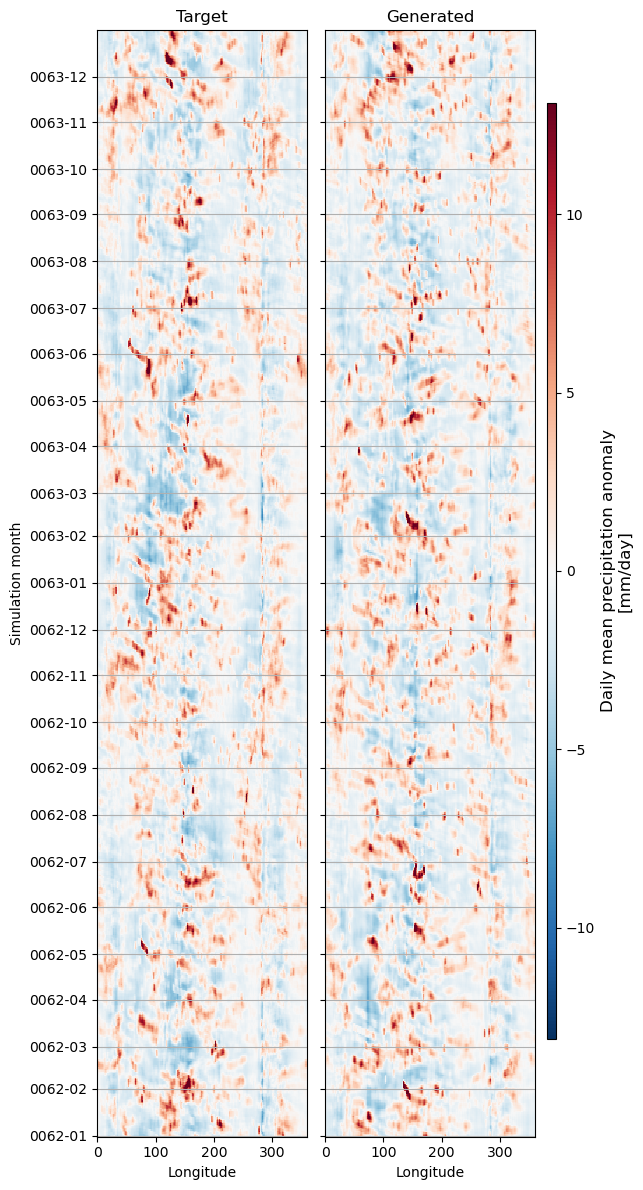

In [23]:
da_anom_lat_mean_rolling5 = da_anom_lat_mean.rolling(time=5).mean()

vmax_abs = np.quantile(np.abs(da_anom_lat_mean_rolling5.isel(time=slice(-730, None))), 0.999)

fig, axs = plot_hovmoller_by_lon(
    da_anom_lat_mean_rolling5.isel(time=slice(-730, None)), 
    var_name="precipitation anomaly",
    time_label="Simulation month",
    norm=TwoSlopeNorm(0.0, -vmax_abs, vmax_abs),
    cmap="RdBu_r"
)

yticks = xr.cftime_range(
    da_anom_lat_mean_rolling5["time"][-730].item(),
    da_anom_lat_mean_rolling5["time"][-1].item(),
    freq="MS",
    calendar="noleap"
).values                     

axs[0].set_yticks(yticks)
axs[0].yaxis.set_major_formatter(CFTimeFormatter("%Y-%m", "noleap"))
axs[0].grid(axis="y")
axs[1].grid(axis="y")

fig.show()

In [24]:
fig.savefig(os.path.join(OUTDIR, f"{FIG_PREFIX}_fig7.png"), bbox_inches="tight")